In [ ]:
#%pip install --upgrade networkx
#%pip install umap-learn
#%pip install seaborn
#%pip install ipywidgets

In [51]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import torch
import networkx as nx
import seaborn as sns 
import umap.umap_ as umap
import tqdm

import glob
import os
from PIL import Image





# META OPT 1.3B

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

cache_dir = "Z:\\LLMCache"

model_id = "facebook/opt-1.3b"
config = AutoConfig.from_pretrained(model_id, output_hidden_states=True)
model = AutoModelForCausalLM.from_pretrained(model_id, config=config)
tokenizer = AutoTokenizer.from_pretrained(model_id)



# GPT2 XL 1.5B

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer
 
cache_dir = "Z:\\LLMCache"
model_id = "gpt2-xl"

config = GPT2Config.from_pretrained(model_id, output_hidden_states=True)
model = GPT2LMHeadModel.from_pretrained(model_id, config=config)
tokenizer = GPT2Tokenizer.from_pretrained(model_id)

# GPT-NEO 1.3B 

In [52]:
from transformers import (
    GPTNeoForCausalLM,
    GPTNeoConfig,
    GPT2Tokenizer
)


model_id = "EleutherAI/gpt-neo-1.3B"
cache_dir = "Z:\\LLMCache"

config = GPTNeoConfig.from_pretrained(model_id, output_hidden_states=True)
model = GPTNeoForCausalLM.from_pretrained(model_id, config=config, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_id)



c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [53]:
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(device)

cuda


## Txt

In [60]:
# Unrelated
""" input_texts = [
    "Gardening is more than just a pastime; it’s a nurturing process that connects us with nature and sparks creativity. Each seed planted represents a small act of hope, carrying the promise of vibrant blossoms or fresh vegetables. Tending to soil, watering regularly, and removing weeds teaches patience and dedication. The rewards are manifold: from the soothing effect of working outdoors to the satisfaction of watching tiny sprouts grow into healthy plants. Gardening also reduces stress and encourages mindfulness. It’s not merely about tending flowers but also fostering one’s sense of purpose, making it a truly enriching and satisfying hobby.",

    "Modern architecture pushes the boundaries of design through innovative materials and cutting-edge construction methods. Sleek lines, open layouts, and sustainable features are hallmarks of these contemporary structures. Steel, glass, and concrete often dominate the aesthetic, giving rise to buildings that seamlessly merge function with striking form. From towering skyscrapers in bustling cities to eco-friendly homes nestled in quiet suburbs, modern architecture reflects the ever-evolving needs of our society. Advanced technologies like 3D printing and virtual reality also shape the field, allowing architects to experiment with bold ideas. Ultimately, modern architecture redefines how we experience and inhabit the spaces we call home.",

    "Classical literature stands as a timeless testament to human creativity, illuminating universal truths across centuries. Works by authors like Homer, Shakespeare, and Tolstoy transport readers into distant realms and eras while grappling with themes such as love, power, and morality. These texts challenge us to question our assumptions, confront human frailties, and celebrate resilience. Often written in elevated language and complex structures, they encourage deep reading and reflection. Though centuries may separate modern audiences from these authors, their words resonate with emotional honesty and vibrant storytelling. Classical literature thus endures as a cornerstone of education, culture, and profound intellectual engagement.",

    "Wildlife conservation is crucial for maintaining the balance of ecosystems worldwide. Every species, from the smallest insects to majestic whales, plays a unique role in the intricate web of life. When one species diminishes or disappears, it affects countless others, disrupting food chains and natural processes. Conservation efforts focus on habitat protection, anti-poaching regulations, and education initiatives that highlight the importance of biodiversity. Protecting endangered species not only preserves natural heritage but also ensures resources like clean water and fertile soil for future generations. Through collective action and responsible stewardship, we can safeguard our planet’s incredible array of life forms.",

    "Ancient mythology offers rich narratives that reveal the values, fears, and aspirations of early civilizations. Myths about gods, heroes, and creatures were deeply intertwined with daily life, often explaining natural phenomena or teaching moral lessons. Greek tales of Zeus and Athena, Norse sagas of Thor and Odin, and Egyptian stories of Ra and Anubis continue to captivate modern audiences. These stories served as both religious texts and cultural touchstones, shaping everything from political power structures to artistic expression. Despite their fantastical elements, myths hold enduring relevance, emphasizing universal themes such as love, betrayal, and the relentless pursuit of knowledge.",

    "Digital art has revolutionized the creative landscape by merging traditional artistic expression with modern technology. Artists can now sketch, paint, and sculpt in virtual environments using advanced software and tools. This flexibility opens up endless possibilities for experimentation, as layers can be added or removed, and color palettes adjusted instantly. Social media platforms provide opportunities for digital artists to share their work globally, garnering feedback and inspiration from diverse audiences. Moreover, new mediums like NFTs have emerged, offering novel ways to buy and sell digital pieces. As technology evolves, digital art continues to expand, reshaping our understanding of creativity.",

    "Personal finance revolves around budgeting, saving, and investing wisely to secure one’s financial well-being. Planning starts with a clear overview of monthly income and expenses, which helps identify unnecessary costs and prioritize essential spending. Building an emergency fund is vital to handle unexpected events like medical bills or car repairs without accruing debt. Investing strategies can vary—some prefer stocks, while others lean toward real estate or mutual funds. It’s also important to manage credit responsibly, aiming to maintain a strong credit score. Good personal finance habits cultivate stability and peace of mind, helping people reach both short-term and long-term goals.",

    "World cuisine is a vibrant tapestry of flavors, reflecting the history, geography, and cultural traditions of diverse regions. From the aromatic spices of Indian curries to the comforting pasta dishes of Italian homes, each culinary style tells a story of local ingredients and techniques passed down through generations. Street food in Southeast Asia, for example, combines sweet, salty, and spicy elements in bold combinations that awaken the palate. Regional specialties often highlight fresh, seasonal produce, celebrating the bounty of land and sea. As cultures interact and globalize, fusion dishes emerge, blending time-honored recipes with modern twists to create mouthwatering new experiences.",
] """

# Some related
""" input_texts = [
    "On a quiet afternoon in a charming town, sunlight filters through ancient trees lining a peaceful boulevard. Neighbors chat while strolling along cobblestone streets, their voices mingling with the soft rustle of leaves in a gentle breeze. Small cafés serve freshly brewed coffee and homemade pastries, adding a welcoming aroma to the air. Children laugh in nearby parks as local artisans display handcrafted goods on quaint sidewalks. Every detail, from the historic architecture to the friendly smiles, creates an atmosphere of warmth and community, inviting everyone to pause and savor the simple, everyday beauty of life.",
    
    "In a serene coastal village, the calming sound of ocean waves sets a tranquil rhythm for daily life. Sun-drenched streets wind past weathered cottages adorned with vibrant blooms and inviting doorways. Locals greet one another with warm smiles, while seaside cafés serve aromatic teas and fresh, locally sourced treats. Children play near the gentle shoreline as fishermen prepare for the day, their boats bobbing in the harbor. The harmonious blend of salty air, soft sea breezes, and timeless traditions creates an ambiance of peaceful coexistence, encouraging residents and visitors alike to embrace the charm of a relaxed, seaside existence.",
    
    "World cuisine is a vibrant tapestry of flavors, reflecting the history, geography, and cultural traditions of diverse regions. From the aromatic spices of Indian curries to the comforting pasta dishes of Italian homes, each culinary style tells a story of local ingredients and techniques passed down through generations. Street food in Southeast Asia, for example, combines sweet, salty, and spicy elements in bold combinations that awaken the palate. Regional specialties often highlight fresh, seasonal produce, celebrating the bounty of land and sea. As cultures interact and globalize, fusion dishes emerge, blending time-honored recipes with modern twists to create mouthwatering new experiences.",
    
    "World cuisine is a vibrant tapestry of flavors, reflecting the history, geography, and cultural traditions of diverse regions. From the aromatic spices of Indian curries to the comforting pasta dishes of Italian homes, each culinary style tells a story of local ingredients and techniques passed down through generations. Street food in Southeast Asia, for example, combines sweet, salty, and spicy elements in bold combinations that awaken the palate. Regional specialties often highlight fresh, seasonal produce, celebrating the bounty of land and sea. As cultures interact and globalize, fusion dishes emerge, blending time-honored recipes with modern twists to create mouthwatering new experiences.",
    
    "World cuisine is a vibrant tapestry of flavors, reflecting the history, geography, and cultural traditions of diverse regions. From the aromatic spices of Indian curries to the comforting pasta dishes of Italian homes, each culinary style tells a story of local ingredients and techniques passed down through generations. Street food in Southeast Asia, for example, combines sweet, salty, and spicy elements in bold combinations that awaken the palate. Regional specialties often highlight fresh, seasonal produce, celebrating the bounty of land and sea. As cultures interact and globalize, fusion dishes emerge, blending time-honored recipes with modern twists to create mouthwatering new experiences.",
    
    "Ancient mythology offers rich narratives that reveal the values, fears, and aspirations of early civilizations. Myths about gods, heroes, and creatures were deeply intertwined with daily life, often explaining natural phenomena or teaching moral lessons. Greek tales of Zeus and Athena, Norse sagas of Thor and Odin, and Egyptian stories of Ra and Anubis continue to captivate modern audiences. These stories served as both religious texts and cultural touchstones, shaping everything from political power structures to artistic expression. Despite their fantastical elements, myths hold enduring relevance, emphasizing universal themes such as love, betrayal, and the relentless pursuit of knowledge.",
    
    "Ancient mythology offers rich narratives that reveal the values, fears, and aspirations of early civilizations. Myths about gods, heroes, and creatures were deeply intertwined with daily life, often explaining natural phenomena or teaching moral lessons. Greek tales of Zeus and Athena, Norse sagas of Thor and Odin, and Egyptian stories of Ra and Anubis continue to captivate modern audiences. These stories served as both religious texts and cultural touchstones, shaping everything from political power structures to artistic expression. Despite their fantastical elements, myths hold enduring relevance, emphasizing universal themes such as love, betrayal, and the relentless pursuit of knowledge.",
    
    "Ancient mythology offers rich narratives that reveal the values, fears, and aspirations of early civilizations. Myths about gods, heroes, and creatures were deeply intertwined with daily life, often explaining natural phenomena or teaching moral lessons. Greek tales of Zeus and Athena, Norse sagas of Thor and Odin, and Egyptian stories of Ra and Anubis continue to captivate modern audiences. These stories served as both religious texts and cultural touchstones, shaping everything from political power structures to artistic expression. Despite their fantastical elements, myths hold enduring relevance, emphasizing universal themes such as love, betrayal, and the relentless pursuit of knowledge.",
]
 """
# Different languages
input_texts = [
    "Gardening is more than just a pastime; it’s a nurturing process that connects us with nature and sparks creativity. Each seed planted represents a small act of hope, carrying the promise of vibrant blossoms or fresh vegetables. Tending to soil, watering regularly, and removing weeds teaches patience and dedication. The rewards are manifold: from the soothing effect of working outdoors to the satisfaction of watching tiny sprouts grow into healthy plants. Gardening also reduces stress and encourages mindfulness. It’s not merely about tending flowers but also fostering one’s sense of purpose, making it a truly enriching and satisfying hobby.",

    "Η κηπουρική είναι κάτι περισσότερο από ένα χόμπι. είναι μια διαδικασία φροντίδας που μας συνδέει με τη φύση και πυροδοτεί τη δημιουργικότητα. Κάθε σπόρος που φυτεύεται αντιπροσωπεύει μια μικρή πράξη ελπίδας, που φέρει την υπόσχεση για ζωντανά άνθη ή φρέσκα λαχανικά. Η φροντίδα του εδάφους, το τακτικό πότισμα και η αφαίρεση των ζιζανίων διδάσκει υπομονή και αφοσίωση. Οι ανταμοιβές είναι πολλαπλές: από το καταπραϋντικό αποτέλεσμα της εργασίας σε εξωτερικούς χώρους μέχρι την ικανοποίηση να παρακολουθείς μικροσκοπικά βλαστάρια να μεγαλώνουν σε υγιή φυτά. Η κηπουρική μειώνει επίσης το άγχος και ενθαρρύνει την επίγνωση. Δεν αφορά απλώς την περιποίηση λουλουδιών, αλλά και την ενίσχυση της αίσθησης του σκοπού, καθιστώντας το ένα πραγματικά εμπλουτιστικό και ικανοποιητικό χόμπι.",

    "Tuinieren is meer dan alleen een tijdverdrijf; het is een verzorgend proces dat ons verbindt met de natuur en creativiteit aanwakkert. Elk geplant zaadje vertegenwoordigt een kleine daad van hoop, met de belofte van levendige bloesems of verse groenten. Het verzorgen van de grond, regelmatig water geven en onkruid verwijderen leert geduld en toewijding. De beloningen zijn veelvoudig: van het rustgevende effect van buiten werken tot de voldoening van het zien uitgroeien van kleine spruitjes tot gezonde planten. Tuinieren vermindert ook stress en stimuleert mindfulness. Het gaat niet alleen om het verzorgen van bloemen, maar ook om het bevorderen van iemands gevoel van doelgerichtheid, waardoor het een werkelijk verrijkende en bevredigende hobby is.",

    "Il giardinaggio è più di un semplice passatempo; è un processo di cura che ci collega alla natura e stimola la creatività. Ogni seme piantato rappresenta un piccolo atto di speranza, che porta con sé la promessa di fiori vivaci o verdure fresche. Prendersi cura del terreno, annaffiare regolarmente e rimuovere le erbacce insegna pazienza e dedizione. Le ricompense sono molteplici: dall'effetto lenitivo del lavoro all'aperto alla soddisfazione di vedere piccoli germogli crescere e diventare piante sane. Il giardinaggio riduce anche lo stress e incoraggia la consapevolezza. Non si tratta solo di prendersi cura dei fiori, ma anche di promuovere il proprio senso di scopo, rendendolo un hobby davvero arricchente e soddisfacente.",

    "Ogrodnictwo to coś więcej niż tylko hobby; to proces pielęgnowania, który łączy nas z naturą i pobudza kreatywność. Każde zasadzone nasionko to mały akt nadziei, niosący obietnicę bujnych kwiatów lub świeżych warzyw. Dbanie o glebę, regularne podlewanie i usuwanie chwastów uczy cierpliwości i poświęcenia. Nagrody są liczne: od kojącego efektu pracy na świeżym powietrzu po satysfakcję z obserwowania, jak maleńkie kiełki wyrastają na zdrowe rośliny. Ogrodnictwo zmniejsza również stres i zachęca do uważności. Nie chodzi tu tylko o pielęgnację kwiatów, ale także o pielęgnowanie poczucia celu, co czyni je naprawdę wzbogacającym i satysfakcjonującym hobby.",
]

input_texts_token_lengths = [
    len(tokenizer.encode(paragraph))
    for paragraph in input_texts
]

print("Token lengths per paragraph:", input_texts_token_lengths)
print("Cumulative sums:", np.cumsum(input_texts_token_lengths))


Token lengths per paragraph: [128, 888, 279, 269, 355]
Cumulative sums: [ 128 1016 1295 1564 1919]


## Colors

In [62]:
input_text = " ".join(input_texts)
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

print(inputs["input_ids"].size())

with torch.no_grad():
    outputs = model(**inputs)
all_hidden_states = outputs.hidden_states 

seq_len = all_hidden_states[1].size()[1]
token_indices = np.arange(seq_len)


# cumulative sums
cumulative_lengths = np.cumsum(input_texts_token_lengths)

seq_len = all_hidden_states[0].size(1)   
token_indices = np.arange(seq_len) 

group_ids = np.searchsorted(cumulative_lengths, token_indices, side="right")

num_groups = group_ids.max() + 1 

base_colors_hex = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#bcbd22",  # olive
]

point_colors = [base_colors_hex[g] for g in group_ids]

cmap = plt.cm.get_cmap("Set1", num_groups)


base_colors_rgb = [mcolors.to_rgb(h) for h in base_colors_hex]

def get_group_fractions(group_ids):
    fractions = np.zeros_like(group_ids, dtype=float)
    unique_groups = np.unique(group_ids)
    
    for g in unique_groups:
        g_indices = np.where(group_ids == g)[0]
        if len(g_indices) <= 1:
            fractions[g_indices] = 0.0
            continue
        local_positions = np.arange(len(g_indices))
        local_fractions = local_positions / (len(g_indices) - 1)
        fractions[g_indices] = local_fractions
    return fractions

def blend_color_and_alpha(base_color, frac, 
                          start_alpha=0.2, end_alpha=1.0, 
                          light_factor=0.5):
    alpha = start_alpha + frac * (end_alpha - start_alpha)
    
    r0, g0, b0 = base_color
    white_blend = light_factor * (1.0 - frac)
    r = (1.0 * white_blend) + r0 * (1.0 - white_blend)
    g = (1.0 * white_blend) + g0 * (1.0 - white_blend)
    b = (1.0 * white_blend) + b0 * (1.0 - white_blend)
    
    return (r, g, b, alpha)

def create_final_colors(group_ids, base_colors_rgb,
                        start_alpha=0.2, end_alpha=1.0, 
                        light_factor=0.5):
    fractions = get_group_fractions(group_ids)
    final_colors = np.zeros((len(group_ids), 4), dtype=float)
    
    for i, g in enumerate(group_ids):
        base_color = base_colors_rgb[g % len(base_colors_rgb)]
        frac       = fractions[i]
        rgba       = blend_color_and_alpha(base_color, frac,
                                           start_alpha=start_alpha,
                                           end_alpha=end_alpha,
                                           light_factor=light_factor)
        final_colors[i] = rgba
    return final_colors



torch.Size([1, 1918])


C:\Users\Danie\AppData\Local\Temp\ipykernel_19364\3470503829.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_groups)


## Cluster Helpers

In [67]:

def compute_cluster_centroids(layer, group_ids):
    """
    Compute the mean hidden state (centroid) for each group.
    layer: 2D numpy array of shape [seq_len, hidden_size]
    group_ids: 1D array-like of length seq_len, each token's group id
    Returns a dictionary: {group_id: centroid vector}
    """
    unique_groups = np.unique(group_ids)
    centroids = {}
    for g in unique_groups:
        indices = np.where(group_ids == g)[0]
        centroids[g] = layer[indices].mean(axis=0)
    return centroids

def compute_umap_centroids(umap_result, group_ids):
    """
    Compute centroids in UMAP space by averaging the UMAP coordinates per group.
    """
    unique_groups = np.unique(group_ids)
    umap_centroids = {}
    for g in unique_groups:
        indices = np.where(group_ids == g)[0]
        umap_centroids[g] = umap_result[indices].mean(axis=0)
    return umap_centroids

def compute_distance_matrix(centroids):
    """
    Compute a pairwise Euclidean distance matrix between centroids.
    centroids: dictionary {group_id: centroid vector}
    Returns:
      groups: sorted list of group IDs
      dist_matrix: 2D numpy array of shape [num_groups, num_groups]
    """
    groups = sorted(centroids.keys())
    num_groups = len(groups)
    dist_matrix = np.zeros((num_groups, num_groups))
    for i, g1 in enumerate(groups):
        for j, g2 in enumerate(groups):
            if i == j:
                dist_matrix[i, j] = 0.0
            else:
                dist_matrix[i, j] = np.linalg.norm(centroids[g1] - centroids[g2])
    
    mean_rows = dist_matrix.mean(0) # mean of each rows -> [1,num_groups]
    avg_distance = mean_rows.mean(0) # mean of all columns -> single value
    #avg_distance = dist_matrix.mean()
    return groups, dist_matrix, avg_distance



def create_graph(umap_matrix, group_ids, k=5, n_candidates=50):
    """
    Create a k-nearest neighbor graph from the UMAP 2D matrix, with node group assignments.
    
    Each node will try to connect to up to k neighbors. If a candidate neighbor already
    has k connections, the node will try the next candidate.
    
    Parameters:
      umap_matrix: numpy array of shape [n_points, 2]
      group_ids: 1D array-like of length n_points, each node's group id
      k: desired number of connections per node (default: 5)
      n_candidates: number of nearest neighbor candidates to consider for each node (default: 50)
      
    Returns:
      G: a networkx Graph with:
         - Node label = integer index
         - 'pos' attribute for each node's (x, y) coordinates
         - 'group' attribute for each node's group ID
    """
    n_points = umap_matrix.shape[0]
    G = nx.Graph()
    
    for i in range(n_points):
        G.add_node(i, 
                   pos=(umap_matrix[i, 0], umap_matrix[i, 1]),
                   group=group_ids[i])

    n_neighbors = min(n_points, n_candidates)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
    nbrs.fit(umap_matrix)
    distances, indices = nbrs.kneighbors(umap_matrix)
    
    for i in range(n_points):
        for j in indices[i][1:]: 
            if G.degree(i) < k and G.degree(j) < k:
                if not G.has_edge(i, j):
                    G.add_edge(i, j)
            if G.degree(i) >= k:
                break  # stop if current node has k connections

    return G

def compute_modularity(G):
    """
    Compute the modularity of the graph based on the 'group' attribute assigned to each node.
    
    Parameters:
      G: a networkx Graph where each node has a 'group' attribute.
      
    Returns:
      mod: modularity value (float)
    """
    # dictionary grouping nodes by their group id
    communities_dict = {}
    for node in G.nodes():
        group = G.nodes[node]['group']
        if group not in communities_dict:
            communities_dict[group] = set()
        communities_dict[group].add(node)
    
    # list of communities
    communities = list(communities_dict.values())
    
    # modularity using networkx built-in function
    mod = nx.algorithms.community.quality.modularity(G, communities)
    return mod


def visualize_graph(G, folder_path, layer_nr, base_colors_rgb=base_colors_rgb):
    """
    Visualize the graph using the node positions stored in the 'pos' attribute,
    and color the nodes by their group IDs using the provided base color mapping.
    
    Parameters:
      G: networkx Graph with node attributes:
         - 'pos': (x, y) position for each node
         - 'group': group ID for each node
      base_colors_rgb: list of RGB tuples (or hex strings) to map group IDs to colors.
    """
    pos = nx.get_node_attributes(G, 'pos')
    
    node_groups = [G.nodes[node]['group'] for node in G.nodes()]
    node_colors = [base_colors_rgb[group % len(base_colors_rgb)] for group in node_groups]
    
    plt.figure(figsize=(8, 8))
    
    nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.8)
    
    nx.draw_networkx_nodes(
        G, pos,
        node_size=25,
        node_color=node_colors
    )
    
    unique_groups = sorted(set(node_groups))
    legend_handles = []
    for group in unique_groups:
        color = base_colors_rgb[group % len(base_colors_rgb)]
        patch = mpatches.Patch(color=color, label=f"Group {group}")
        legend_handles.append(patch)
    plt.legend(handles=legend_handles, title="Group ID", loc="best")
    
    plt.title("Graph from 2D UMAP")
    plt.axis("off")
    plt.tight_layout()
    
    save_path = f"images/{folder_path}/graph_layer{layer_nr}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()



In [64]:
folder_path = "test"

# MAin
input_text = " ".join(input_texts)
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)
    
# all_hidden_states is a tuple of length number_of_layers
all_hidden_states = outputs.hidden_states  

avg_dists_full      = []
avg_dists_umap      = []
layer_modularities  = []
for layer_nr, layer_state in tqdm.tqdm(enumerate(all_hidden_states)):
    layer = layer_state.cpu().squeeze().numpy()  # [seq_len, hidden_size]
    
    orig_centroids = compute_cluster_centroids(layer, group_ids)
    groups, orig_dist_matrix, avg_dist_full = compute_distance_matrix(orig_centroids)
    avg_dists_full.append(avg_dist_full)
    
    reducer = umap.UMAP(
        n_neighbors=5,
        n_components=2,
        metric='euclidean',
        repulsion_strength=2,
        random_state=42
    )
    umap_result = reducer.fit_transform(layer)
    
    G = create_graph(umap_result, group_ids, k=5)
    layer_modularities.append(compute_modularity(G))
    
    umap_centroids = compute_umap_centroids(umap_result, group_ids)
    umap_groups, umap_dist_matrix, avg_dist_umap = compute_distance_matrix(umap_centroids)
    avg_dists_umap.append(avg_dist_umap)
    
    final_colors = create_final_colors(
        group_ids=group_ids, 
        base_colors_rgb=base_colors_rgb,
        start_alpha=0.2,  
        end_alpha=1.0,     
        light_factor=0.5   
    )
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))
    
    ax1.scatter(umap_result[:, 0], umap_result[:, 1],
                c=final_colors, s=20)
    
    for g, centroid in umap_centroids.items():
        label_color = base_colors_rgb[g % len(base_colors_rgb)]
        ax1.text(centroid[0], centroid[1], f"{g}",
                 fontsize=14, fontweight='bold',
                 color="black")
    
    legend_handles = []
    unique_groups = sorted(np.unique(group_ids))
    for g in unique_groups:
        label_color = base_colors_rgb[g % len(base_colors_rgb)]
        patch = mpatches.Patch(color=label_color, label=f"Group {g}")
        legend_handles.append(patch)
    ax1.legend(handles=legend_handles, title="Groups", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    ax1.set_title(f"{model_id} UMAP – Layer: {layer_nr}")
    ax1.axis("off")
    
    sns.heatmap(orig_dist_matrix, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=groups, yticklabels=groups, ax=ax2)
    ax2.set_title(f"Embedded Space Centroid Distances – Layer: {layer_nr}")
    
    sns.heatmap(umap_dist_matrix, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=umap_groups, yticklabels=umap_groups, ax=ax3)
    ax3.set_title(f"UMAP (2D) Centroid Distances – Layer: {layer_nr}")
    
    plt.tight_layout()
    
    visualize_graph(G, folder_path, layer_nr)

    save_path = f"images/{folder_path}/layer{layer_nr}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()


0it [00:00, ?it/s]c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
1it [00:04,  4.76s/it]c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2it [00:09,  4.71s/it]c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: 

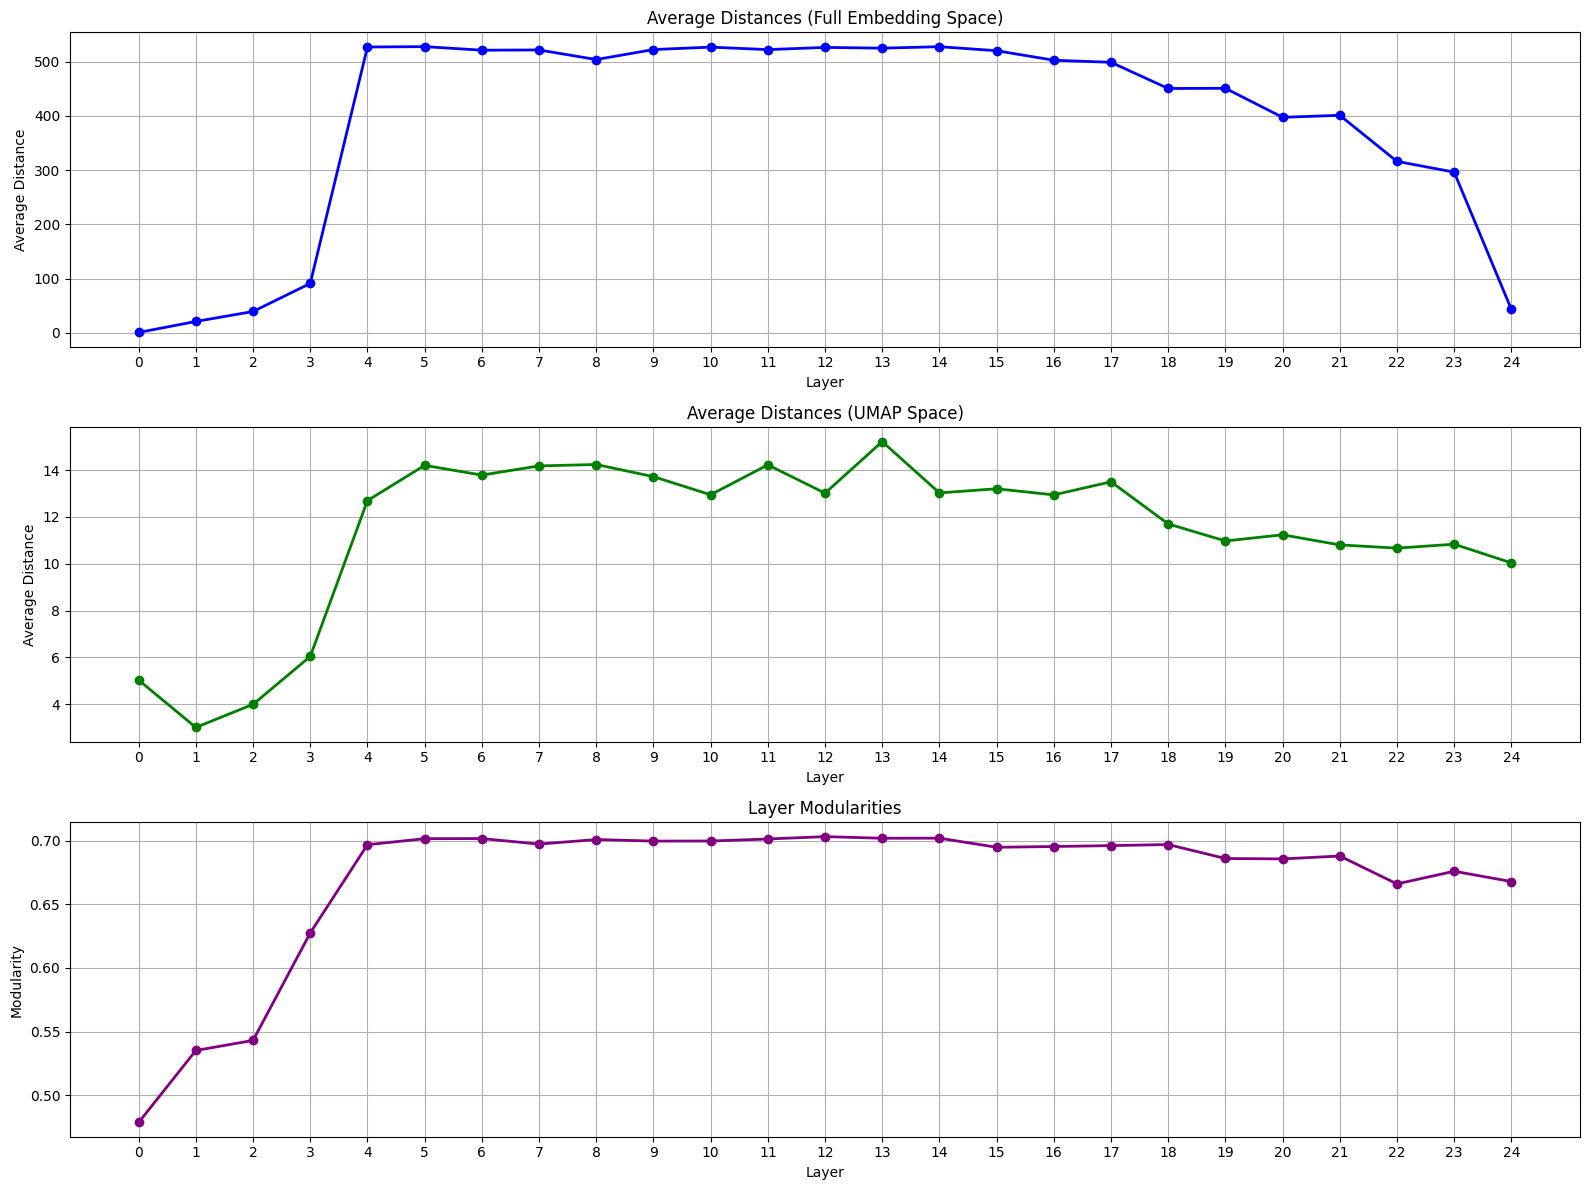

In [65]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))

x_values_full = list(range(len(avg_dists_full)))
ax1.plot(x_values_full, avg_dists_full, marker='o', linestyle='-', linewidth=2, color='blue')
ax1.set_title("Average Distances (Full Embedding Space)")
ax1.set_xlabel("Layer")
ax1.set_ylabel("Average Distance")
ax1.set_xticks(x_values_full)
ax1.set_xticklabels([str(x) for x in x_values_full])
ax1.grid(True)

x_values_umap = list(range(len(avg_dists_umap)))
ax2.plot(x_values_umap, avg_dists_umap, marker='o', linestyle='-', linewidth=2, color='green')
ax2.set_title("Average Distances (UMAP Space)")
ax2.set_xlabel("Layer")
ax2.set_ylabel("Average Distance")
ax2.set_xticks(x_values_umap)
ax2.set_xticklabels([str(x) for x in x_values_umap])
ax2.grid(True)

x_values_mod = list(range(len(layer_modularities)))
ax3.plot(x_values_mod, layer_modularities, marker='o', linestyle='-', linewidth=2, color='purple')
ax3.set_title("Layer Modularities")
ax3.set_xlabel("Layer")
ax3.set_ylabel("Modularity")
ax3.set_xticks(x_values_mod)
ax3.set_xticklabels([str(x) for x in x_values_mod])
ax3.grid(True)

plt.tight_layout()
save_path = f"images/{folder_path}/measurements.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()




In [66]:
import os
import glob

image_folder = f"images/5lang_gptneo/"
png_files = glob.glob(os.path.join(image_folder, "layer*.png"))
png_files = sorted(png_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].replace("layer", "")))

frames = []
for file in png_files:
    print(file)
    frame = Image.open(file)
    frames.append(frame)

if frames:
    frames[0].save(
        f"images/{folder_path}/gif.gif",
        save_all=True,
        append_images=frames[1:], 
        duration=1000,  
        loop=1
    )
    print("GIF successfully saved as test.gif")
else:
    print("No images found in the folder!")

No images found in the folder!


In [50]:
#nx.write_gexf(G, "testing.gexf")
